In [ ]:
import os 

In [1]:
import sys
print(sys.path)

['c:\\users\\paul pc\\appdata\\local\\programs\\python\\python36\\python36.zip', 'c:\\users\\paul pc\\appdata\\local\\programs\\python\\python36\\DLLs', 'c:\\users\\paul pc\\appdata\\local\\programs\\python\\python36\\lib', 'c:\\users\\paul pc\\appdata\\local\\programs\\python\\python36', '', 'C:\\Users\\Paul PC\\AppData\\Roaming\\Python\\Python36\\site-packages', 'c:\\users\\paul pc\\appdata\\local\\programs\\python\\python36\\lib\\site-packages', 'c:\\users\\paul pc\\appdata\\local\\programs\\python\\python36\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\Paul PC\\.ipython']


In [4]:
!mkdir data

In [110]:
import os

import logging
import glob
import re
from PIL import Image
import pandas as pd
import cv2 as cv
import copy as cp
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

random_seed = 42
%matplotlib inline

In [3]:
import os

import glob
import re
from PIL import Image
import pandas as pd
import copy as cp
import numpy as np
import matplotlib.pyplot as plt

random_seed = 42
%matplotlib inline

In [175]:
class DataLoader:
    
    def __init__(self,names_path,desc_path,label_path,in_img_path,out_img_path,verbose,list_file_dir):
        self.verbose = verbose
        self.names_path = names_path
        self.desc_path = desc_path
        self.in_img_path = in_img_path
        self.out_img_path = out_img_path
        self.label_path = label_path
        self.list_file_dir = list_file_dir
        self.gtsdb = pd.read_csv(os.path.abspath(label_path), sep=";", header=None,names=
                                 ["img", "x1", "y1", "x2", "y2","id"])
        self.complete_dataset()
        print(self.gtsdb.head())
        
    def complete_dataset(self):
        for file_name in glob.glob(os.path.join(self.in_img_path,'*.ppm')):
            name = os.path.split(file_name)[-1]
            if(name not in self.gtsdb.img.tolist()):
                if(self.verbose):
                    print(str.format("adding {0} to dataset",name))
                image = Image.open(file_name)
                self.gtsdb.loc[len(self)] = [name,None,None,None,None,None]
            
            
        
    def __getitem__(self,key):
        if(isinstance(key,slice) ):
            indices = key.indices(len(self))
            return [self[ii] for ii in range(*indices)]
        return {'img':self.load_image(key),
                'label':self.gtsdb.iloc[key]['id'],
                'name':self.gtsdb.iloc[key]['img'],
                'x1':self.gtsdb.iloc[key]['x1'],
               'x2':self.gtsdb.iloc[key]['x2'],
               'y1':self.gtsdb.iloc[key]['y1'],
                'y2':self.gtsdb.iloc[key]['y2']}
        
    def __len__(self):
        return len(self.gtsdb)
        
    
    def load_image(self,idx):
        if(self.verbose):
            print("Loading image at {0}".format(self.gtsdb.iloc[idx]['img']))
        return Image.open(os.path.join(self.in_img_path,self.gtsdb.iloc[idx]['img']))
    
    def format_class_name(self,class_name):
        class_name = class_name.lower().replace(' ','-')+'\n'
        if(self.verbose):
            print(class_name)
        return class_name
    
    def dump_class_name(self,path,class_name):
        with open(os.path.abspath(path),'w') as f:
            f.write(class_name+os.linesep)
            
    def dump_classes(self):
        lines = []
        with open(os.path.abspath(self.desc_path),'r') as desc_file:
            lines = desc_file.readlines()
        if(self.verbose):
            print("".join(lines))
        pattern = re.compile('^\d{1,2}\s=\s(.*)')
        search  = lambda l : re.search(pattern,l)
        names =[match.group(1) for match in map(search,lines) if(match is not None) ]
        with open(os.path.abspath(self.names_path), 'w') as names_file:
            for n in names:
                names_file.write(self.format_class_name(n))
   
    def convert_all(self):
        cache = []
        for im in tqdm(self):
            if(im['name'] not in cache):
                self.ppm2jpg(im['img'],im['name'])
                cache.append(im['name'])
                    
    
    def ppm2jpg(self,img,img_name):
        os.makedirs(self.out_img_path,exist_ok=True)
        img.save(os.path.join(self.out_img_path,os.path.splitext(img_name)[0]+'.jpg'))
    
    
    def get_bb_coordinates(self,example):
        im_height = example['img'].height
        im_width = example['img'].width
        x_center = (example['x2']+example['x1'])/(2.0*im_width)
        y_center = (example['y2']+example['y1'])/(2.0*im_height)
        height = (example['y2']-example['y1'])/im_height
        width = (example['x2']-example['x1'])/im_width
        return{'label':example['label'],
               'x_center':x_center,
               'y_center':y_center,
               'width':width,
               'height':height}
    

    
    def dump_split(self):
        group_by_img = self.gtsdb.groupby('img')
        count = 0
        train_set = []
        test_set = []
        with open(os.path.join(self.list_file_dir,'train.txt'),'w') as train_file, open(os.path.join(self.list_file_dir,'test.txt'),'w') as test_file: 
            for name,group in tqdm(group_by_img):
                base_name=os.path.splitext(name)[0]
                line = os.path.join(self.out_img_path,os.path.splitext(name)[0]+'.jpg')+'\n'
                if(self.verbose):
                    print(str.format("Appending line {0}",line))
                if(int(base_name)<600):
                    train_file.write(line)
                else:
                    test_file.write(line)
                count += 1
        return train_set,test_set
        
    def dump_all(self):
        for img_name in self.gtsdb.img:
            if(self.verbose):
                print(img_name)
            with open(os.path.join(self.out_img_path,os.path.splitext(img_name)[0]+'.txt'),'w') as label_file:
                for index, row in self.gtsdb.loc[self.gtsdb['img'] == img_name].iterrows():
                    example = self[index]
                    if(example['label'] != None):
                        bb_coordinates = self.get_bb_coordinates(example)
                        if(self.verbose):
                            print(index)
                            print(bb_coordinates)
                        sep = ' '
                        label_file.write(str(bb_coordinates['label'])+sep+str(bb_coordinates['x_center'])+sep+
                                         str(bb_coordinates['y_center'])
                                         +sep+str(bb_coordinates['width'])+sep+str(bb_coordinates['height'])+'\n')
 
    
                

In [5]:

    
def inv_conv_coordinates(x_center,y_center,rel_height,rel_width, im_height,im_width):
    width = rel_width*im_width 
    height = rel_height*im_height
    y1 = y_center*im_height - height//2
    y2 = y_center*im_height + height//2
    x1 = x_center*im_width - width//2
    x2 = x_center*im_width + width//2
    return x1,y1,x2,y2
    
    
def draw_bb(im,relative_center,relative_dimensions,im_dimensions):    
    im = cp.copy(im)
    print(relative_center)
    print(relative_dimensions)
    print(im_dimensions)
    x_center,y_center = relative_center
    height, width = relative_dimensions
    im_height, im_width,_ = im_dimensions
    x1,y1,x2,y2=inv_conv_coordinates(x_center,y_center,height,width, im_height,im_width)
    print(x1,y1,x2,y2)
    return cv.rectangle(im,(int(x1),int(y1)),(int(x2),int(y2)),color=(255,0,0),thickness=2)

def display_image(im):
    plt.figure(figsize=(20,20))
    plt.subplot(1,2,1),plt.imshow(im)
    plt.show()
    
def PIL2Np(im):
    pil_image = im.convert('RGB') 
    open_cv_image = np.array(pil_image)
    return open_cv_image[:, :, ::-1].copy()

def data_split(dataset,validation_split,shuffle_dataset):
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))
    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_set, val_set = dataset[split:], dataset[:split]
    return train_set,val_set

def IJCNN_data_split(dataset):
    group_by_img = dataset.gtsdb.groupby('img')
    count = 0
    train_set = []
    test_set = []
    for name,group in group_by_img:
        for index,example in group.iterrows():
            print(index)
            if(count<600):
                train_set.append(example)
            else:
                test_set.append(example)
        count += 1
    return train_set,test_set


In [177]:
dataLoader = DataLoader(verbose=False,names_path=os.path.join('data','obj.names'),desc_path=os.path.
           join('FullIJCNN2013','ReadMe.txt'),in_img_path='FullIJCNN2013',out_img_path= os.path.join('data','obj'),
                        label_path=os.path.join('FullIJCNN2013','gt.txt'),list_file_dir='data')
assert len(dataLoader.gtsdb.groupby('img')) == 900

         img   x1   y1    x2   y2  id
0  00000.ppm  774  411   815  446  11
1  00001.ppm  983  388  1024  432  40
2  00001.ppm  386  494   442  552  38
3  00001.ppm  973  335  1031  390  13
4  00002.ppm  892  476  1006  592  39


In [7]:
train_set,test_set = data_split(dataLoader,0.8,True)
IJCNN_train,IJCNN_test = IJCNN_data_split(dataLoader)

In [162]:
img = dataLoader[2]

print(img)
# check that all of the we only have one row per no-object image
assert len(dataLoader.gtsdb.loc[~dataLoader.gtsdb['id'].isin(range(44))].groupby('img')) == len(dataLoader.gtsdb.
                                                                                                loc[~dataLoader.gtsdb['id'].
                                                                                                    isin(range(44))])


{'img': <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1360x800 at 0x1EB1F3975C0>, 'label': 38, 'name': '00001.ppm', 'x1': 386, 'x2': 442, 'y1': 494, 'y2': 552}


In [165]:
dataLoader.gtsdb.tail()


,img,x1,y1,x2,y2,id
1367,00878.ppm,None,None,None,None,None
1368,00880.ppm,None,None,None,None,None
1369,00883.ppm,None,None,None,None,None
1370,00890.ppm,None,None,None,None,None
1371,00892.ppm,None,None,None,None,None


Loading image at 00013.ppm
(800, 1360, 3)
(0.7952205882352941, 0.398125)
(0.09375, 0.05661764705882353)
(800, 1360, 3)
1043.5 281.5 1119.5 355.5


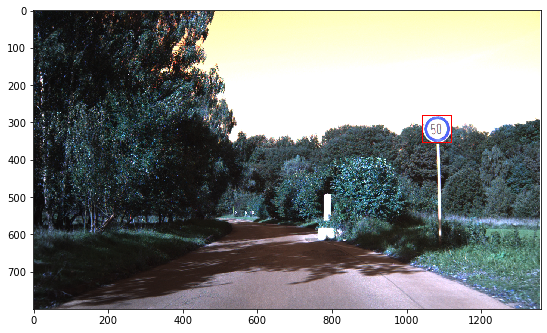

In [143]:
# Sanity check
example = dataLoader[20]

im = PIL2Np(example['img'])

print(im.shape)

bb_coordinates = dataLoader.get_bb_coordinates(example)

new_im = draw_bb(im,(bb_coordinates['x_center'],bb_coordinates['y_center']),(bb_coordinates['height'],bb_coordinates['width']),
        im.shape)
display_image(new_im)

In [170]:
dataLoader.convert_all()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1372/1372 [00:38<00:00, 35.26it/s]


In [171]:
dataLoader.dump_all()

In [172]:
dataLoader.dump_classes()

In [178]:
dataLoader.dump_split()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 900/900 [00:00<00:00, 7517.81it/s]


([], [])

,img,x1,y1,x2,y2,id
1213,00108.ppm,None,None,None,None,None
1214,00139.ppm,None,None,None,None,None
1215,00145.ppm,None,None,None,None,None
1216,00213.ppm,None,None,None,None,None
1217,00235.ppm,None,None,None,None,None
